References

1. https://cs231n.github.io/neural-networks-2/#reg
2. https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/DL2/Bayesian_Neural_Networks/dl2_bnn_tut2_student_with_answers.html

In [60]:
### Regular Dropout

import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd

import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [61]:
from tueplots import bundles
plt.rcParams.update(bundles.beamer_moml())


# Also add despine to the bundle using rcParams
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Increase font size to match Beamer template
plt.rcParams['font.size'] = 16
# Make background transparent
plt.rcParams['figure.facecolor'] = 'none'

Inspired from: https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/DL2/Bayesian_Neural_Networks/dl2_bnn_tut2_student_with_answers.html

In [62]:
def get_simple_data_train():
    x = torch.linspace(-2, 4, 300)
    x = torch.hstack([x, torch.linspace(6, 8, 300)])
    f = lambda x: torch.sin(x)
    eps = torch.randn_like(x) * 0.1
    f_x = f(x) 
    y_train = f_x + eps
    x_train = x[:, None]
    return x_train, y_train, f

In [63]:
def plot_generic(add_to_plot=None):
    fig, ax = plt.subplots()

    plt.xlabel("X",)
    plt.ylabel("Y",)

    x_train, y_train, true_func = get_simple_data_train()
    
    x_all = torch.linspace(-2, 8, 1000)

    ax.plot(x_train, y_train, 'C0', marker='o', ms= 4, linestyle='none', alpha=0.2, label='Observations')
    ax.plot(x_all, true_func(x_all), 'C1', linewidth=1, label="true function")
    if add_to_plot is not None:
        add_to_plot(ax)

    plt.legend(loc=4, frameon=False)
    plt.show()

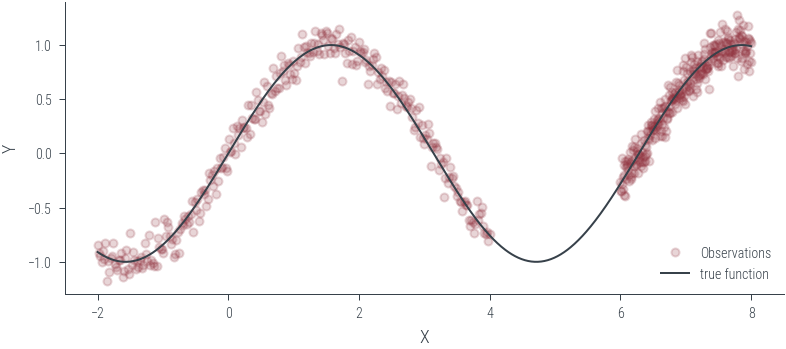

In [64]:
plot_generic()

In [244]:
# Define a simple MLP without using nn.Linear

input_dim = 1

hidden_l1_dim = 100
hidden_l2_dim = 50


def init_params():
    W1 = nn.Parameter(torch.randn(input_dim, hidden_l1_dim, requires_grad=True).to(device))
    b1 = nn.Parameter(torch.zeros(hidden_l1_dim, requires_grad=True).to(device))
    W2 = nn.Parameter(torch.randn(hidden_l1_dim, hidden_l2_dim, requires_grad=True).to(device))
    b2 = nn.Parameter(torch.zeros(hidden_l2_dim, requires_grad=True).to(device))
    W3 = nn.Parameter(torch.randn(hidden_l2_dim, 1, requires_grad=True).to(device))
    b3 = nn.Parameter(torch.zeros(1, requires_grad=True).to(device))
    return [W1, b1, W2, b2, W3, b3]


def mlp(x, params, p=0.0):
    W1, b1, W2, b2, W3, b3 = params
    h1 = torch.tanh(x @ W1 + b1)
    h2 = torch.tanh(h1 @ W2 + b2)
    return (h2 @ W3 + b3).ravel()

In [245]:
train_x, train_y, true_func = get_simple_data_train()
train_x = train_x.to(device)
train_y = train_y.to(device)


In [246]:
train_x.shape

torch.Size([600, 1])

In [247]:
test_x = torch.linspace(-2, 8, 1000)[:, None]
test_x = test_x.to(device)

In [248]:
parameters = init_params()


with torch.no_grad():
    y_hat_untrained = mlp(test_x, parameters).ravel()
# Detach and convert to numpy
y_hat_untrained = y_hat_untrained.cpu().detach().numpy()

In [249]:
def plot_predictions(x_test, y_preds):
    def add_predictions(ax):
        ax.plot(x_test, y_preds, 'C2', label='neural net prediction')

    plot_generic(add_predictions)


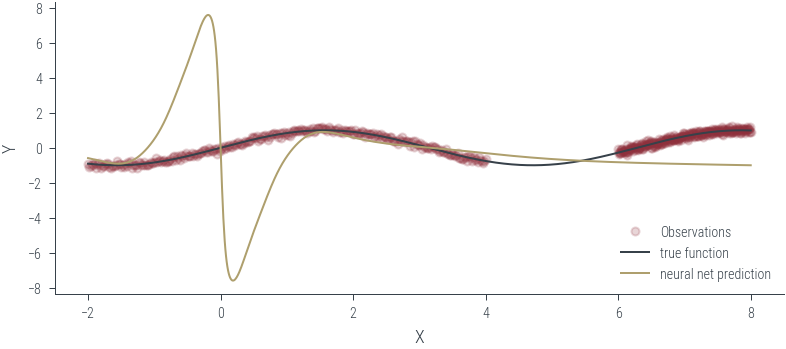

In [250]:
# Plot the untrained model
plot_predictions(test_x.cpu(), y_hat_untrained)

In [251]:
# Modify the train function to pass the dropout flag and dropout probability
def train(params, opt, fwd_func, x_train, y_train, epochs=1000, dropout=False, p=0.0):
    for i in range(epochs):
        y_hat = fwd_func(x_train, params, p)  # Pass the dropout flag and probability to fwd_func
        loss = F.mse_loss(y_hat, y_train)
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        if i % 300 == 0:
            print(f"Epoch {i}, loss {loss.item():.3f}")
    return params

In [252]:
parameters = init_params()

# Continue with optimizer
optimizer = torch.optim.Adam(parameters, lr=3e-4)

trained_params = train(parameters, optimizer, mlp, train_x, train_y, epochs=6000, dropout=False, p=0.0)

Epoch 0, loss 37.181
Epoch 300, loss 0.035
Epoch 600, loss 0.019
Epoch 900, loss 0.013
Epoch 1200, loss 0.011
Epoch 1500, loss 0.011
Epoch 1800, loss 0.010
Epoch 2100, loss 0.010
Epoch 2400, loss 0.010
Epoch 2700, loss 0.010
Epoch 3000, loss 0.009
Epoch 3300, loss 0.009
Epoch 3600, loss 0.009
Epoch 3900, loss 0.009
Epoch 4200, loss 0.009
Epoch 4500, loss 0.009
Epoch 4800, loss 0.009
Epoch 5100, loss 0.009
Epoch 5400, loss 0.009
Epoch 5700, loss 0.009


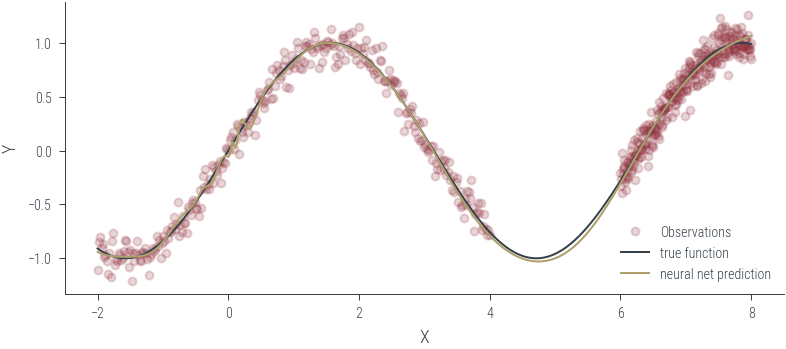

In [253]:
# Plot the trained model
with torch.no_grad():
    y_hat_trained = mlp(test_x, trained_params).ravel()
# Detach and convert to numpy
y_hat_trained = y_hat_trained.cpu().detach().numpy()

plot_predictions(test_x.cpu(), y_hat_trained)

In [254]:
### Now adding dropout to the model by manually masking the activations
W1, b1, W2, b2, W3, b3 = parameters
h1 = torch.relu(test_x @ W1 + b1)
h1.shape


torch.Size([1000, 100])

In [255]:
# probability of dropping out each neuron
p = 0.2

In [256]:
mask = torch.rand_like(h1) > p
mask.shape

torch.Size([1000, 100])

In [257]:
h1.shape

torch.Size([1000, 100])

In [258]:
mask.sum()

tensor(80191, device='cuda:0')

In [259]:
mask.numel()

100000

In [260]:
masked_activations = h1 * mask
masked_activations.shape

torch.Size([1000, 100])

In [261]:
pd.DataFrame(masked_activations.cpu().detach().numpy()).head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.000000,0.0,0.000000,0.0,0.0,1.406280,0.0,0.849969,2.711409,0.0,...,0.0,0.0,0.549452,1.080862,1.229222,0.0,0.290182,0.0,0.0,0.0
1,2.478225,0.0,6.020751,0.0,0.0,1.399225,0.0,0.845771,0.000000,0.0,...,0.0,0.0,0.546559,1.075420,1.223090,0.0,0.288728,0.0,0.0,0.0
2,2.465552,0.0,5.990534,0.0,0.0,1.392170,0.0,0.841573,2.684318,0.0,...,0.0,0.0,0.543667,1.069978,1.216957,0.0,0.287274,0.0,0.0,0.0
3,2.452878,0.0,5.960318,0.0,0.0,0.000000,0.0,0.837375,2.670772,0.0,...,0.0,0.0,0.540774,1.064536,0.000000,0.0,0.285819,0.0,0.0,0.0
4,0.000000,0.0,5.930102,0.0,0.0,0.000000,0.0,0.833176,2.657227,0.0,...,0.0,0.0,0.537881,1.059094,1.204693,0.0,0.284365,0.0,0.0,0.0


In [262]:
pd.DataFrame(h1.cpu().detach().numpy()).head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,2.490899,0.0,6.050967,0.0,0.0,1.406280,0.0,0.849969,2.711409,0.0,...,0.0,0.0,0.549452,1.080862,1.229222,0.0,0.290182,0.0,0.0,0.0
1,2.478225,0.0,6.020751,0.0,0.0,1.399225,0.0,0.845771,2.697863,0.0,...,0.0,0.0,0.546559,1.075420,1.223090,0.0,0.288728,0.0,0.0,0.0
2,2.465552,0.0,5.990534,0.0,0.0,1.392170,0.0,0.841573,2.684318,0.0,...,0.0,0.0,0.543667,1.069978,1.216957,0.0,0.287274,0.0,0.0,0.0
3,2.452878,0.0,5.960318,0.0,0.0,1.385116,0.0,0.837375,2.670772,0.0,...,0.0,0.0,0.540774,1.064536,1.210825,0.0,0.285819,0.0,0.0,0.0
4,2.440205,0.0,5.930102,0.0,0.0,1.378060,0.0,0.833176,2.657227,0.0,...,0.0,0.0,0.537881,1.059094,1.204693,0.0,0.284365,0.0,0.0,0.0


In [263]:
pd.DataFrame(mask.cpu().detach().numpy()).head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,False,True,False,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True,False,True,...,True,True,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,False,True,True,False,...,True,True,True,True,True,True,True,True,True,True
3,True,True,True,True,True,False,True,True,True,False,...,False,True,True,True,False,True,True,True,True,True
4,False,True,True,True,True,False,True,True,True,True,...,True,True,True,True,True,False,True,True,False,False


In [264]:
### Rewriting the model with dropout

def mlp_dropout(x, params, p=0.0, training=True):
    W1, b1, W2, b2, W3, b3 = params
    h1 = torch.tanh(x @ W1 + b1)
    #h2 = torch.sin(h1 @ W2 + b2)
    #h3 = h2 @ W3 + b3
    #return h3
    if training:
        # probability of dropping out each neuron
        mask = torch.rand_like(h1) > p
        h1 = h1 * mask
        # scale activations to account for dropout
        #h1 = h1 / (1 - p)
    h2 = torch.tanh(h1 @ W2 + b2)
    if training:
        # probability of dropping out each neuron
        mask = torch.rand_like(h2) > p
        h2 = h2 * mask
        # scale activations to account for dropout
        #h2 = h2 / (1 - p)
    h3 = h2 @ W3 + b3
    return h3.ravel()

In [270]:
# Train the model
p = 0.1
parameters = init_params()

# Continue with optimizer
optimizer = torch.optim.Adam(parameters, lr=3e-4)
trained_params = train(parameters, optimizer, mlp_dropout, train_x, train_y, epochs=10000, dropout=True, p=p)

Epoch 0, loss 16.168
Epoch 300, loss 4.485
Epoch 600, loss 3.601
Epoch 900, loss 3.233
Epoch 1200, loss 2.866
Epoch 1500, loss 2.475
Epoch 1800, loss 2.395
Epoch 2100, loss 2.020
Epoch 2400, loss 1.824
Epoch 2700, loss 1.661
Epoch 3000, loss 1.409
Epoch 3300, loss 1.200
Epoch 3600, loss 1.128
Epoch 3900, loss 1.141
Epoch 4200, loss 0.861
Epoch 4500, loss 0.780
Epoch 4800, loss 0.758
Epoch 5100, loss 0.647
Epoch 5400, loss 0.528
Epoch 5700, loss 0.459
Epoch 6000, loss 0.385
Epoch 6300, loss 0.362
Epoch 6600, loss 0.326
Epoch 6900, loss 0.273
Epoch 7200, loss 0.240
Epoch 7500, loss 0.216
Epoch 7800, loss 0.200
Epoch 8100, loss 0.175
Epoch 8400, loss 0.163
Epoch 8700, loss 0.147
Epoch 9000, loss 0.135
Epoch 9300, loss 0.131
Epoch 9600, loss 0.107
Epoch 9900, loss 0.100


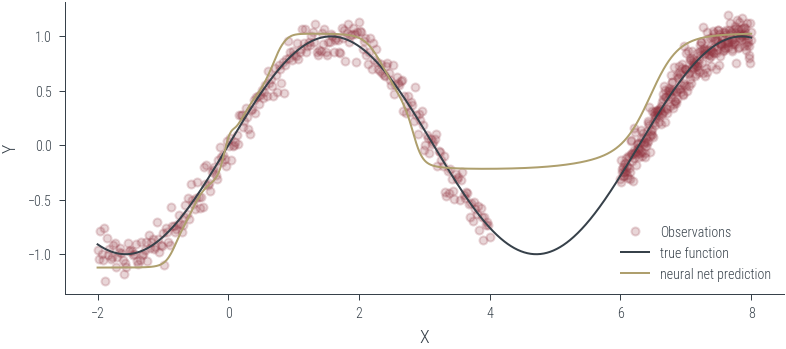

In [271]:
# Predictions with dropout
with torch.no_grad():
    y_hat_dropout = mlp_dropout(test_x, trained_params, training=False).ravel()

# Detach and convert to numpy
y_hat_dropout = y_hat_dropout.cpu().detach().numpy()

plot_predictions(test_x.cpu(), y_hat_dropout)

    

In [272]:
# Get the predictions for the test set with dropout set to True

preds = []
for i in range(100):
    with torch.no_grad():
        y_hat_dropout = mlp_dropout(test_x, trained_params, training=True, p=p).ravel()
    # Detach and convert to numpy
    y_hat_dropout = y_hat_dropout.cpu().detach().numpy()
    preds.append(y_hat_dropout)

In [273]:
# Plot MC dropout predictions

preds = np.array(preds)
preds.shape

(100, 1000)

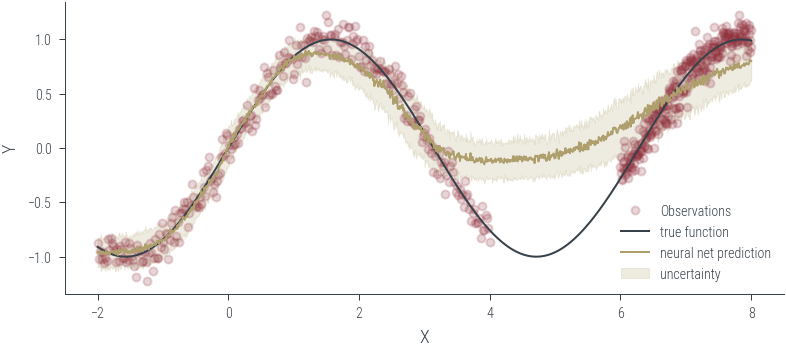

In [274]:
# Plot mean and variance of MC dropout predictions

mean = preds.mean(axis=0)
std = preds.std(axis=0)

def plot_predictions_with_uncertainty(x_test, y_preds, y_std):
    def add_predictions(ax):
        ax.plot(x_test, y_preds, 'C2', label='neural net prediction')
        ax.fill_between(x_test.ravel(), y_preds - y_std, y_preds + y_std, alpha=0.2, color='C2', label='uncertainty')

    plot_generic(add_predictions)

plot_predictions_with_uncertainty(test_x.cpu(), mean, std)


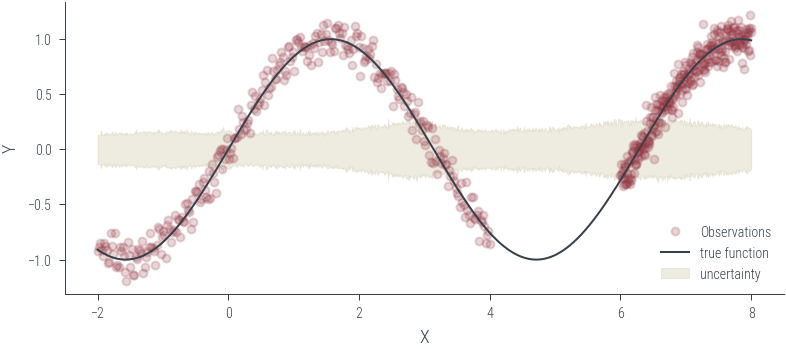

In [275]:
# Just plot the uncertainty

def plot_uncertainty(x_test, y_std):
    def add_predictions(ax):
        ax.fill_between(x_test.ravel(), -y_std, y_std, alpha=0.2, color='C2', label='uncertainty')

    plot_generic(add_predictions)
    
plot_uncertainty(test_x.cpu(), std)